In [1]:
import pandas as pd
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler   

In [2]:
# Getting the block info dataset
dataset = pd.read_csv('./datasets/dataset.csv')

In [3]:
dataset.columns

Index(['Unnamed: 0', 'block_base_fee', 'difficulty', 'gas_limit', 'gas_used',
       'number', 'size', 'time', 'total_difficulty', '0.25 Tip (Gwei)',
       '0.75 Tip (Gwei)', 'AVG Tip (Gwei)', 'Block Base Fees (ETH)',
       'Block Tips (ETH)', 'Max Tip (Gwei)', 'Median Tip (Gwei)',
       'Min Tip (Gwei)', 'block_number'],
      dtype='object')

In [4]:
# 2317337 blocks 
len(dataset.index)

2317337

In [5]:
# Data type and column name transformantions 
dataset=[dataset['block_number']<=13165745]
dataset = dataset.drop(columns=['block_number'])
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.rename(columns={"0.25 Tip (Gwei)":"Q1_tip", "0.75 Tip (Gwei)":"Q3_tip", "AVG Tip (Gwei) ":"avg_tip", "Block Base Fees (ETH)":"block_base_fees_eth", "Block Tips (ETH)":"block_tips_eth", "Max Tip (Gwei)": "max_tip", "Median Tip (Gwei)": "median_tip", "Min Tip (Gwei)":"min_tip","AVG Tip (Gwei)":"avg_tip"})
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['time'] = dataset['time'].dt.strftime('%Y-%m-%d %H:%M:00')
#dataset['time'] = dataset['time'].dt.floor('Min')
dataset['time'] = pd.to_datetime(dataset['time'])

In [6]:
dataset

,block_base_fee,difficulty,gas_limit,gas_used,number,size,time,total_difficulty,Q1_tip,Q3_tip,avg_tip,block_base_fees_eth,block_tips_eth,max_tip,median_tip,min_tip
0,1000000000,7742494561645080,30029122,30025257,12965000,584,2021-08-05 12:33:00,28494409340649014490153,22.000000,32.000000,35.122037,0.030025,0.813216,1558.000000,25.000000,22.000000
1,1124967822,7742495635386904,29999798,29985144,12965001,579,2021-08-05 12:33:00,28494417083144649877057,25.875032,44.900606,33.106784,0.033732,0.926795,98.875032,28.380162,21.375032
2,1265451421,7738716193681762,29970503,29950343,12965002,577,2021-08-05 12:34:00,28494424821860843558819,20.734549,25.484549,24.922555,0.037901,0.712779,77.734549,20.734549,20.734549
3,1423420054,7742495937440032,29941236,29933895,12965003,586,2021-08-05 12:34:00,28494432564356780998851,25.576580,34.876580,31.892835,0.042609,0.965993,128.576580,26.576580,0.000000
4,1601260312,7742497011181856,29911998,29895283,12965004,579,2021-08-05 12:34:00,28494440306853792180707,31.273740,45.398740,49.536780,0.047870,1.400710,498.398740,45.398740,28.098740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317332,15429869588,12011638584426950,30000000,28150948,15282332,586,2022-08-05 12:32:00,55656481592363825782644,1.500000,4.417552,5.822693,0.434365,0.130254,104.570130,2.000000,1.000000
2317333,17120848026,12005842246001134,30000000,3846298,15282333,579,2022-08-05 12:33:00,55656493598206071783778,1.696058,4.000000,3.776143,0.065852,0.009934,14.573996,2.426766,1.000000
2317334,15529507719,12011773193137050,30000000,12975312,15282334,579,2022-08-05 12:33:00,55656505609979264920828,1.500000,4.925271,5.430084,0.201500,0.066612,147.495325,2.072444,0.000000
2317335,15267487653,12017707036243247,30000000,9966549,15282335,588,2022-08-05 12:33:00,55656517627686301164075,1.500000,3.505081,3.862013,0.152164,0.042536,49.670078,2.000000,0.000000


In [7]:
# eth price dataset from Binance
eth_price = pd.read_csv('./datasets/eth_price.csv')
eth_price

,Unnamed: 0,datetime,eth_price
0,0,2021-08-05 12:33:00,2615.68
1,1,2021-08-05 12:34:00,2608.04
2,2,2021-08-05 12:35:00,2615.22
3,3,2021-08-05 12:36:00,2620.99
4,4,2021-08-05 12:37:00,2618.12
...,...,...,...
525995,525995,2022-08-05 19:08:00,1667.74
525996,525996,2022-08-05 19:09:00,1668.26
525997,525997,2022-08-05 19:10:00,1669.79
525998,525998,2022-08-05 19:11:00,1670.99


In [8]:
# Data type and column name transformantions 
eth_price['datetime'] = pd.to_datetime(eth_price['datetime'])
eth_price = eth_price[eth_price['datetime'] <= '2022-08-05 12:33:00']
eth_price = eth_price.rename(columns={'datetime': 'time'})
eth_price = eth_price.drop(columns=['Unnamed: 0'])
eth_price = eth_price.drop_duplicates(subset=['time'])

# Join dataset and eth price
ds_aux = dataset.merge(eth_price, on='time', how='left', indicator=True)


# There are gaps in the Binance API, so we get the last known eth price value and we insert that into empty timestamps
empty_values = ds_aux[ds_aux['_merge'] == 'left_only']
for row in empty_values.iterrows():
    i = 1
    price = 0
    while price == 0:
        if math.isnan(ds_aux.loc[row[0]-i]['eth_price']):
            i=i+1
        else:
            price=ds_aux.loc[row[0]-i]['eth_price']
    ds_aux.at[row[0],'eth_price'] = price


In [9]:
dataset = ds_aux
dataset = dataset.drop(columns=['_merge'])
# Drop empty blocks with no tip data 
dataset = dataset.dropna()
dataset = dataset.drop(columns=['total_difficulty'])

dataset

,block_base_fee,difficulty,gas_limit,gas_used,number,size,time,Q1_tip,Q3_tip,avg_tip,block_base_fees_eth,block_tips_eth,max_tip,median_tip,min_tip,eth_price
0,1000000000,7742494561645080,30029122,30025257,12965000,584,2021-08-05 12:33:00,22.000000,32.000000,35.122037,0.030025,0.813216,1558.000000,25.000000,22.000000,2615.68
1,1124967822,7742495635386904,29999798,29985144,12965001,579,2021-08-05 12:33:00,25.875032,44.900606,33.106784,0.033732,0.926795,98.875032,28.380162,21.375032,2615.68
2,1265451421,7738716193681762,29970503,29950343,12965002,577,2021-08-05 12:34:00,20.734549,25.484549,24.922555,0.037901,0.712779,77.734549,20.734549,20.734549,2608.04
3,1423420054,7742495937440032,29941236,29933895,12965003,586,2021-08-05 12:34:00,25.576580,34.876580,31.892835,0.042609,0.965993,128.576580,26.576580,0.000000,2608.04
4,1601260312,7742497011181856,29911998,29895283,12965004,579,2021-08-05 12:34:00,31.273740,45.398740,49.536780,0.047870,1.400710,498.398740,45.398740,28.098740,2608.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317332,15429869588,12011638584426950,30000000,28150948,15282332,586,2022-08-05 12:32:00,1.500000,4.417552,5.822693,0.434365,0.130254,104.570130,2.000000,1.000000,1694.59
2317333,17120848026,12005842246001134,30000000,3846298,15282333,579,2022-08-05 12:33:00,1.696058,4.000000,3.776143,0.065852,0.009934,14.573996,2.426766,1.000000,1696.40
2317334,15529507719,12011773193137050,30000000,12975312,15282334,579,2022-08-05 12:33:00,1.500000,4.925271,5.430084,0.201500,0.066612,147.495325,2.072444,0.000000,1696.40
2317335,15267487653,12017707036243247,30000000,9966549,15282335,588,2022-08-05 12:33:00,1.500000,3.505081,3.862013,0.152164,0.042536,49.670078,2.000000,0.000000,1696.40


In [10]:
def reorder_dataset(dataset, n):
    
    ds = dataset.copy()
    for i in range (1,n+1):
        ds['block_base_fee_'+str(i)] = np.nan
        ds['difficulty_'+str(i)] = np.nan
        ds['gas_limit_'+str(i)] = np.nan
        ds['gas_used_'+str(i)] = np.nan
        ds['size_'+str(i)] = np.nan
        ds['Q1_tip_'+str(i)] = np.nan
        ds['Q3_tip_'+str(i)] = np.nan
        ds['avg_tip_'+str(i)] = np.nan
        ds['block_base_fees_eth_'+str(i)] = np.nan
        ds['block_tips_eth_'+str(i)] = np.nan
        ds['max_tip_'+str(i)] = np.nan
        ds['median_tip_'+str(i)] = np.nan
        ds['eth_price_'+str(i)] = np.nan

    for i in range (1,n+1):        
        ds['block_base_fee_'+str(i)] = ds['block_base_fee'].shift(i)
        ds['difficulty_'+str(i)] = ds['difficulty'].shift(i)
        ds['gas_limit_'+str(i)] = ds['gas_limit'].shift(i)
        ds['gas_used_'+str(i)] = ds['gas_used'].shift(i)
        ds['size_'+str(i)] = ds['size'].shift(i)
        ds['Q1_tip_'+str(i)] = ds['Q1_tip'].shift(i)
        ds['Q3_tip_'+str(i)] = ds['Q3_tip'].shift(i)
        ds['avg_tip_'+str(i)] = ds['avg_tip'].shift(i)
        ds['block_base_fees_eth_'+str(i)] = ds['block_base_fees_eth'].shift(i)
        ds['block_tips_eth_'+str(i)] = ds['block_tips_eth'].shift(i)
        ds['max_tip_'+str(i)] = ds['max_tip'].shift(i)
        ds['median_tip_'+str(i)] = ds['median_tip'].shift(i)
        ds['eth_price_'+str(i)] = ds['eth_price'].shift(i)
    
    return ds

dataset_n3 = reorder_dataset(dataset,3)
dataset_n10 = reorder_dataset(dataset,10)

/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_1226/2578902769.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds['Q3_tip_'+str(i)] = np.nan
/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_1226/2578902769.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds['avg_tip_'+str(i)] = np.nan
/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_1226/2578902769.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

In [11]:
dataset_n3 = dataset_n3.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

dataset_n10 = dataset_n10.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

In [12]:
# Drop not relevant columns
dataset_n3 = dataset_n3.drop(columns=['time'])
dataset_n10 = dataset_n10.drop(columns=['time'])

#### Drop blocks without full history ####
dataset_n3 = dataset_n3.dropna()
dataset_n10 = dataset_n10.dropna()

In [13]:
dataset_n10

,number,min_tip,block_base_fee_1,difficulty_1,gas_limit_1,gas_used_1,size_1,Q1_tip_1,Q3_tip_1,avg_tip_1,...,gas_used_10,size_10,Q1_tip_10,Q3_tip_10,avg_tip_10,block_base_fees_eth_10,block_tips_eth_10,max_tip_10,median_tip_10,eth_price_10
10,12965010,17.755300,2.884438e+09,7.738716e+15,29824428.0,29812344.0,586.0,18.999937,28.115562,28.045876,...,30025257.0,584.0,22.000000,32.000000,35.122037,0.030025,0.813216,1558.000000,25.000000,2615.68
11,12965011,0.000000,3.244700e+09,7.738717e+15,29853552.0,29834559.0,565.0,17.755300,27.755300,35.210364,...,29985144.0,579.0,25.875032,44.900606,33.106784,0.033732,0.926795,98.875032,28.380162,2615.68
12,12965012,23.282891,3.649772e+09,7.742497e+15,29824400.0,29821506.0,586.0,26.739024,34.850228,40.502357,...,29950343.0,577.0,20.734549,25.484549,24.922555,0.037901,0.712779,77.734549,20.734549,2608.04
13,12965013,0.000000,4.105905e+09,7.731157e+15,29795276.0,29791321.0,583.0,23.478533,28.894095,30.082695,...,29933895.0,586.0,25.576580,34.876580,31.892835,0.042609,0.965993,128.576580,26.576580,2608.04
14,12965014,16.804192,4.619007e+09,7.727383e+15,29766181.0,29751403.0,586.0,22.769790,27.380993,31.652582,...,29895283.0,579.0,31.273740,45.398740,49.536780,0.047870,1.400710,498.398740,45.398740,2608.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317332,15282332,1.000000,1.484742e+10,1.201157e+16,30000000.0,19707465.0,568.0,1.500000,4.000000,3.646355,...,29998248.0,570.0,2.827984,12.532887,42.758306,0.348311,1.161369,3569.836618,5.242669,1699.70
2317333,15282333,1.000000,1.542987e+10,1.201164e+16,30000000.0,28150948.0,586.0,1.500000,4.417552,5.822693,...,30011977.0,571.0,2.000000,2.000000,2.611320,0.392025,0.090481,86.937727,2.000000,1698.53
2317334,15282334,0.000000,1.712085e+10,1.200584e+16,30000000.0,3846298.0,579.0,1.696058,4.000000,3.776143,...,30048870.0,574.0,1.400000,1.500000,1.589108,0.441513,0.055825,11.981554,1.400000,1698.53
2317335,15282335,0.000000,1.552951e+10,1.201177e+16,30000000.0,12975312.0,579.0,1.500000,4.925271,5.430084,...,9795136.0,565.0,1.492843,4.564780,4.087525,0.161900,0.028598,46.471371,2.046634,1698.53


In [14]:
X = dataset_n10.drop('min_tip', axis=1)
y = dataset_n10['min_tip']

X_3 = dataset_n3.drop('min_tip', axis=1)
y_3 = dataset_n3['min_tip']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_3, y_3, test_size=0.2, random_state=10)
    
def avoid_data_leakage(X_test, X_train, y_train, n=3):
    id_for_delete = []
    for row in X_test['number'].tolist():
        block_number = int(row)
        id_for_delete = id_for_delete + [x for x in range(block_number-n,block_number)]
    
    X_train = X_train[X_train['number'].isin(id_for_delete)]
    y_train= y_train.loc[X_train.index]

    return X_train, y_train


X_train, y_train = avoid_data_leakage(X_test, X_train, y_train, 10)
X_train_3, y_train_3 = avoid_data_leakage(X_test_3, X_train_3, y_train_3, 3)


In [15]:
X_train = X_train.drop('number', axis=1)
X_test = X_test.drop('number', axis=1)

X_train_3 = X_train_3.drop('number', axis=1)
X_test_3 = X_test_3.drop('number', axis=1)

In [158]:
####### N = 3 #######
# Aplly log to big numbers such as difficulty and total_difficulty so it doesn't mess with other inferior values
for i in range(1,4):
    X_train_3['difficulty_'+str(i)] = X_train_3['difficulty_'+str(i)].apply(int)
    X_test_3['difficulty_'+str(i)] = X_test_3['difficulty_'+str(i)].apply(int)

    X_train_3['difficulty_'+str(i)] = np.log10(X_train_3['difficulty_'+str(i)])
    X_test_3['difficulty_'+str(i)] = np.log10(X_test_3['difficulty_'+str(i)])

model_3 = LinearRegression()
model_3.fit(X_train_3, y_train_3)

# making predictions
predictions_3 = model_3.predict(X_test_3)
predictions_3 = np.maximum(predictions_3, 0.)

########N = 10 SCALED #######
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)


# making predictions
predictions_scaled = model_scaled.predict(X_test_scaled)
predictions_scaled = np.maximum(predictions_scaled, 0.)

########N = 10 SCALED LASSO #######
model_lasso = Lasso()
model_lasso.fit(X_train_scaled, y_train)


# making predictions
predictions_lasso = model_lasso.predict(X_test_scaled)
predictions_lasso = np.maximum(predictions_lasso, 0.)

####### N = 10 #######
# Aplly log to big numbers such as difficulty and total_difficulty so it doesn't mess with other inferior values
for i in range(1,11):
    X_train['difficulty_'+str(i)] = X_train['difficulty_'+str(i)].apply(int)
    X_test['difficulty_'+str(i)] = X_test['difficulty_'+str(i)].apply(int)

    X_train['difficulty_'+str(i)] = np.log10(X_train['difficulty_'+str(i)])
    X_test['difficulty_'+str(i)] = np.log10(X_test['difficulty_'+str(i)])

model = LinearRegression()
model.fit(X_train, y_train)

# making predictions
predictions = model.predict(X_test)
predictions = np.maximum(predictions, 0.)



In [159]:
# model evaluation n 3 
print('mean_squared_error for model with info for 3 blocks: ', mean_squared_error(y_test_3, predictions_3))
print('mean_absolute_error for model with info for 3 blocks: ', mean_absolute_error(y_test_3, predictions_3))

# model evaluation n 10 
print('mean_squared_error for model with info for 10 blocks: ', mean_squared_error(y_test, predictions))
print('mean_absolute_error for model with info for 10 blocks: ', mean_absolute_error(y_test, predictions))

# model evaluation n 10 scaled
print('mean_squared_error for model with info for 10 blocks and scaled: ', mean_squared_error(y_test, predictions_scaled))
print('mean_absolute_error for model with info for 10 blocks and scaled: ', mean_absolute_error(y_test, predictions_scaled))

# model evaluation n 10 scaled lasso
print('mean_squared_error for model with info for 10 blocks and scaled LASSO: ', mean_squared_error(y_test, predictions_lasso))
print('mean_absolute_error for model with info for 10 blocks and scaled LASSO: ', mean_absolute_error(y_test, predictions_lasso))

mean_squared_error for model with info for 3 blocks:  1000.1411494281436
mean_absolute_error for model with info for 3 blocks:  1.4375372676282143
mean_squared_error for model with info for 10 blocks:  756.7801758156913
mean_absolute_error for model with info for 10 blocks:  1.5394172665674162
mean_squared_error for model with info for 10 blocks and scaled:  1121.1390832119923
mean_absolute_error for model with info for 10 blocks and scaled:  3.2558115375460455
mean_squared_error for model with info for 10 blocks and scaled LASSO:  747.4510554715819
mean_absolute_error for model with info for 10 blocks and scaled LASSO:  1.268073153124193


In [160]:
# model evaluation n 3 
y_pred_3 = model_3.predict(X_test_3)
y_pred_3 = np.maximum(y_pred_3, 0.)

# model evaluation n 10 
y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0.)

# model evaluation n 10 scaled
y_pred_scaled = model_scaled.predict(X_test_scaled)
y_pred_scaled = np.maximum(y_pred_scaled, 0.)

# model evaluation n 10 scaled LASSO
y_pred_lasso = model_scaled.predict(X_test_scaled)
y_pred_lasso = np.maximum(y_pred_lasso, 0.)

In [161]:
print('Accuracy for model with info for 3 blocks: ', model_3.score(X_test_3, y_test_3))
print('Accuracy for model with info for 10 blocks: ', model.score(X_test, y_test))
print('Accuracy for model with info for 10 blocks and scaled: ', model_scaled.score(X_test_scaled, y_test))
print('Accuracy for model with info for 10 blocks and scaled with LASSO: ', model_lasso.score(X_test_scaled, y_test))

Accuracy for model with info for 3 blocks:  0.2115960013503616
Accuracy for model with info for 10 blocks:  0.621346883404088
Accuracy for model with info for 10 blocks and scaled:  0.36727311813399954
Accuracy for model with info for 10 blocks and scaled with LASSO:  0.6564709600314977


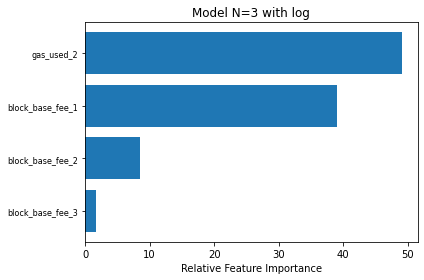

In [20]:
feature_importance = abs(model_3.coef_)
total_feature_importance =  feature_importance.sum()
feature_importance = 100.0 * (feature_importance / total_feature_importance)
column_names_ids = np.argsort(feature_importance)
feature_importance = np.array([i for i in feature_importance if i>1])
column_names_ids = column_names_ids[:len(feature_importance)]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_test.columns)[column_names_ids], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.title('Model N=3 with log')

plt.tight_layout()   
plt.show()

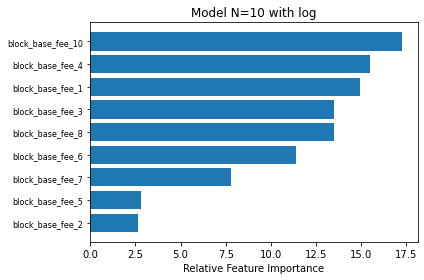

In [21]:
feature_importance = abs(model.coef_)
total_feature_importance =  feature_importance.sum()
feature_importance = 100.0 * (feature_importance / total_feature_importance)
column_names_ids = np.argsort(feature_importance)
feature_importance = np.array([i for i in feature_importance if i>1])
column_names_ids = column_names_ids[:len(feature_importance)]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_test.columns)[column_names_ids], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.title('Model N=10 with log')

plt.tight_layout()   
plt.show()

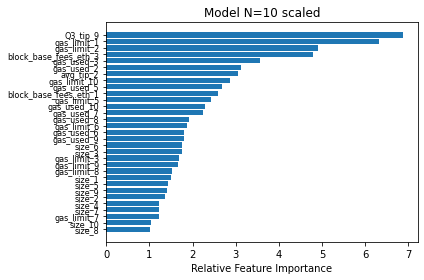

In [22]:
feature_importance = abs(model_scaled.coef_)
total_feature_importance =  feature_importance.sum()
feature_importance = 100.0 * (feature_importance / total_feature_importance)
column_names_ids = np.argsort(feature_importance)
feature_importance = np.array([i for i in feature_importance if i>1])
column_names_ids = column_names_ids[:len(feature_importance)]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_test.columns)[column_names_ids], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.title('Model N=10 scaled')

plt.tight_layout()   
plt.show()

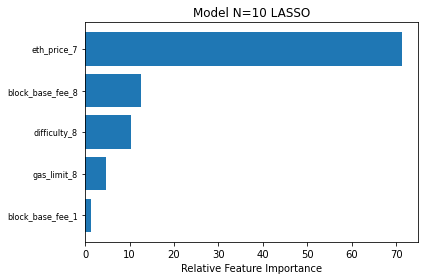

In [162]:
feature_importance = abs(model_lasso.coef_)
total_feature_importance =  feature_importance.sum()
feature_importance = 100.0 * (feature_importance / total_feature_importance)
column_names_ids = np.argsort(feature_importance)
feature_importance = np.array([i for i in feature_importance if i>1])
column_names_ids = column_names_ids[:len(feature_importance)]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_test.columns)[column_names_ids], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.title('Model N=10 LASSO')

plt.tight_layout()   
plt.show()

In [163]:
#### Real data validation ####
# Getting the block info dataset
dataset_validation = pd.read_csv('./datasets/dataset_validation.csv')

# Data type and column name transformantions 
dataset_validation = dataset_validation.drop(columns=['block_number'])
dataset_validation = dataset_validation.drop(columns=['Unnamed: 0'])
dataset_validation = dataset_validation.rename(columns={"0.25 Tip (Gwei)":"Q1_tip", "0.75 Tip (Gwei)":"Q3_tip", "AVG Tip (Gwei) ":"avg_tip", "Block Base Fees (ETH)":"block_base_fees_eth", "Block Tips (ETH)":"block_tips_eth", "Max Tip (Gwei)": "max_tip", "Median Tip (Gwei)": "median_tip", "Min Tip (Gwei)":"min_tip","AVG Tip (Gwei)":"avg_tip"})
dataset_validation['time'] = pd.to_datetime(dataset_validation['time'])
dataset_validation['time'] = dataset_validation['time'].dt.strftime('%Y-%m-%d %H:%M:00')
dataset_validation['time'] = pd.to_datetime(dataset_validation['time'])

In [164]:
# eth price dataset from Binance
eth_price_validation = pd.read_csv('./datasets/eth_price_validation.csv')

# Data type and column name transformantions 
eth_price_validation['datetime'] = pd.to_datetime(eth_price_validation['datetime'])
eth_price_validation = eth_price_validation[eth_price_validation['datetime'] <= '2022-08-22 08:22:00']
eth_price_validation = eth_price_validation.rename(columns={'datetime': 'time'})
eth_price_validation = eth_price_validation.drop(columns=['Unnamed: 0'])
eth_price_validation = eth_price_validation.drop_duplicates(subset=['time'])

# Join dataset and eth price
ds_aux = dataset_validation.merge(eth_price_validation, on='time', how='left', indicator=True)


# There are gaps in the Binance API, so we get the last known eth price value and we insert that into empty timestamps
empty_values = ds_aux[ds_aux['_merge'] == 'left_only']
for row in empty_values.iterrows():
    i = 1
    price = 0
    while price == 0:
        if math.isnan(ds_aux.loc[row[0]-i]['eth_price']):
            i=i+1
        else:
            price=ds_aux.loc[row[0]-i]['eth_price']
    ds_aux.at[row[0],'eth_price'] = price


eth_price_validation

,time,eth_price
0,2022-08-07 01:50:00,1677.45
1,2022-08-07 01:51:00,1677.47
2,2022-08-07 01:52:00,1676.72
3,2022-08-07 01:53:00,1676.46
4,2022-08-07 01:54:00,1676.78
...,...,...
21988,2022-08-22 08:18:00,1534.20
21989,2022-08-22 08:19:00,1532.43
21990,2022-08-22 08:20:00,1538.20
21991,2022-08-22 08:21:00,1537.20


In [165]:
dataset_validation = ds_aux
dataset_validation = dataset_validation.drop(columns=['_merge'])
# Drop empty blocks with no tip data 
dataset_validation = dataset_validation.dropna()
dataset_validation = dataset_validation.drop(columns=['total_difficulty'])

# Aplly log to big numbers such as difficulty and total_difficulty so it doesn't mess with other inferior values
dataset_validation_log = dataset_validation
dataset_validation_log['difficulty'] = dataset_validation_log["difficulty"].apply(int)
dataset_validation_log['difficulty'] = np.log10(dataset_validation_log['difficulty'])
dataset_validation_log

,block_base_fee,difficulty,gas_limit,gas_used,number,size,time,Q1_tip,Q3_tip,avg_tip,block_base_fees_eth,block_tips_eth,max_tip,median_tip,min_tip,eth_price
0,2609643471,16.081750,29941325,1613612,15292336,580,2022-08-07 01:50:00,1.016714,2.390357,1.843746,0.004211,0.002570,5.405000,1.464105,1.00000,1677.45
1,2318598073,16.081752,29970563,29964580,15292337,579,2022-08-07 01:50:00,1.500000,3.000000,4.269277,0.069476,0.089162,57.681402,2.000000,1.01627,1677.45
2,2608307136,16.081967,29999830,24681522,15292338,568,2022-08-07 01:51:00,1.346408,2.500000,3.354953,0.064377,0.057082,53.391693,1.519037,0.00000,1677.47
3,2818746700,16.081757,30000000,29981801,15292339,568,2022-08-07 01:51:00,1.500000,2.500000,5.552565,0.084511,0.114856,97.181253,2.000000,1.50000,1677.47
4,3170662551,16.081123,30000000,15217285,15292340,579,2022-08-07 01:52:00,1.500000,2.000000,2.425209,0.048249,0.031185,26.829337,2.000000,1.00000,1676.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,67811693821,16.063835,30000000,27882533,15392331,575,2022-08-22 20:20:00,1.000000,1.500000,4.040411,1.890762,0.117520,132.852429,1.500000,0.00000,1537.80
99996,75091580349,16.063840,30029295,19521870,15392332,573,2022-08-22 20:20:00,1.500000,2.000000,7.149901,1.465928,0.085250,803.003658,2.000000,0.00000,1537.80
99997,77909283106,16.063421,29999971,8766387,15392333,586,2022-08-22 20:21:00,1.500000,2.060179,6.939045,0.682983,0.035976,269.702217,2.000000,0.00000,1537.80
99998,73862152798,16.063426,30029266,11659860,15392334,571,2022-08-22 20:21:00,2.229428,3.137847,5.746562,0.861222,0.061071,161.139051,3.137847,1.00000,1537.80


In [166]:
dataset_validation_n3_log = reorder_dataset(dataset_validation_log,3)
dataset_validation_n10_log = reorder_dataset(dataset_validation_log,10)
dataset_validation_n10_scaled = reorder_dataset(dataset_validation,10)

dataset_validation_n3_log = dataset_validation_n3_log.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

dataset_validation_n10_log = dataset_validation_n10_log.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

dataset_validation_n10_scaled = dataset_validation_n10_scaled.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

# Drop not relevant columns
dataset_validation_n3_log = dataset_validation_n3_log.drop(columns=['time'])
dataset_validation_n10_log = dataset_validation_n10_log.drop(columns=['time'])
dataset_validation_n10_scaled = dataset_validation_n10_scaled.drop(columns=['time'])

#### Drop blocks without full history ####
dataset_validation_n3_log = dataset_validation_n3_log.dropna()
dataset_validation_n10_log = dataset_validation_n10_log.dropna()
dataset_validation_n10_scaled = dataset_validation_n10_scaled.dropna()

/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_1226/2578902769.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds['Q3_tip_'+str(i)] = np.nan
/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_1226/2578902769.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds['avg_tip_'+str(i)] = np.nan
/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_1226/2578902769.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

In [167]:
##### N=3 with log #####
y_validation = dataset_validation_n3_log['min_tip']
X_validation_n3_log = dataset_validation_n3_log.drop('min_tip', axis=1)
X_validation_n3_log = X_validation_n3_log.drop('number', axis=1)

y_val_pred_n3_log = model_3.predict(X_validation_n3_log)
y_val_pred_n3_log = np.maximum(y_val_pred_n3_log, 0.)

print('Accuracy for model with info for 3 blocks with log: ', model_3.score(X_validation_n3_log, y_validation))
print('mean_squared_error for model with info for 3 blocks with log: ', mean_squared_error(y_validation, y_val_pred_n3_log))
print('mean_absolute_error for model with info for 3 blocks with log: ', mean_absolute_error(y_validation, y_val_pred_n3_log))

Accuracy for model with info for 3 blocks with log:  -10759.196767493346
mean_squared_error for model with info for 3 blocks with log:  99979.10472009126
mean_absolute_error for model with info for 3 blocks with log:  316.1845273577234


In [118]:
##### N=10 with log #####
y_validation = dataset_validation_n10_log['min_tip']
X_validation_n10_log = dataset_validation_n10_log.drop('min_tip', axis=1)
X_validation_n10_log = X_validation_n10_log.drop('number', axis=1)

y_val_pred_n10_log = model.predict(X_validation_n10_log)
y_val_pred_n10_log = np.maximum(y_val_pred_n10_log, 0.)

print('Accuracy for model with info for 10 blocks with log: ', model.score(X_validation_n10_log, y_validation))
print('mean_squared_error for model with info for 10 blocks with log: ', mean_squared_error(y_validation, y_val_pred_n10_log))
print('mean_absolute_error for model with info for 10 blocks with log: ', mean_absolute_error(y_validation, y_val_pred_n10_log))

Accuracy for model with info for 10 blocks with log:  0.22157741023837607
mean_squared_error for model with info for 10 blocks with log:  6.555699166416427
mean_absolute_error for model with info for 10 blocks with log:  0.6771668257422181


In [119]:
##### N=10 with scaled #####
y_validation = dataset_validation_n10_scaled['min_tip']
X_validation_n10_scaled = dataset_validation_n10_scaled.drop('min_tip', axis=1)
X_validation_n10_scaled = X_validation_n10_scaled.drop('number', axis=1)

scaler_validation = StandardScaler()
X_validation_n10_scaled = scaler_validation.fit_transform(X_validation_n10_scaled)

y_val_pred_n10_scaled = model_scaled.predict(X_validation_n10_scaled)
y_val_pred_n10_scaled = np.maximum(y_val_pred_n10_scaled, 0.)

print('Accuracy for model with info for 10 blocks with log: ', model_scaled.score(X_validation_n10_scaled, y_validation))
print('mean_squared_error for model with info for 10 blocks with log: ', mean_squared_error(y_validation, y_val_pred_n10_scaled))
print('mean_absolute_error for model with info for 10 blocks with log: ', mean_absolute_error(y_validation, y_val_pred_n10_scaled))

Accuracy for model with info for 10 blocks with log:  -112.1873417162078
mean_squared_error for model with info for 10 blocks with log:  819.96245365612
mean_absolute_error for model with info for 10 blocks with log:  3.9699154991514667


In [168]:
##### N=10 with scaled LASSO#####
y_validation = dataset_validation_n10_scaled['min_tip']
X_validation_n10_scaled = dataset_validation_n10_scaled.drop('min_tip', axis=1)
X_validation_n10_scaled = X_validation_n10_scaled.drop('number', axis=1)

scaler_validation = StandardScaler()
X_validation_n10_scaled = scaler_validation.fit_transform(X_validation_n10_scaled)

y_val_pred_lasso = model_lasso.predict(X_validation_n10_scaled)
y_val_pred_lasso = np.maximum(y_val_pred_lasso, 0.)

print('Accuracy for model with info for 10 blocks scaled LASSO: ', model_lasso.score(X_validation_n10_scaled, y_validation))
print('mean_squared_error for model with info for 10 blocks scaled LASSO: ', mean_squared_error(y_validation, y_val_pred_lasso))
print('mean_absolute_error for model with info for 10 blocks scaled LASSO: ', mean_absolute_error(y_validation, y_val_pred_lasso))

Accuracy for model with info for 10 blocks scaled LASSO:  -91.02032781488057
mean_squared_error for model with info for 10 blocks scaled LASSO:  853.1317456843788
mean_absolute_error for model with info for 10 blocks scaled LASSO:  1.6551046923088244


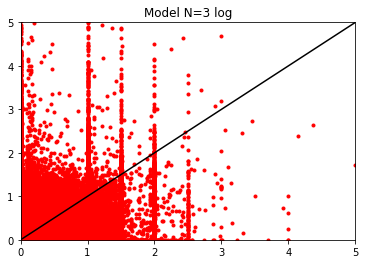

In [121]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 
y_validation = dataset_validation_n3_log['min_tip']

plt.plot(y_validation,y_val_pred_n3_log,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N=3 log')


plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

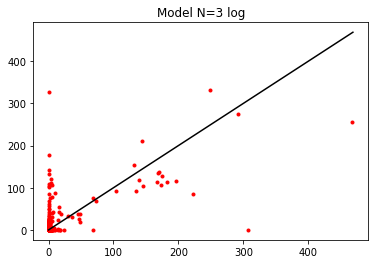

In [122]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 
y_validation = dataset_validation_n3_log['min_tip']

plt.plot(y_validation,y_val_pred_n3_log,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N=3 log')

plt.show()

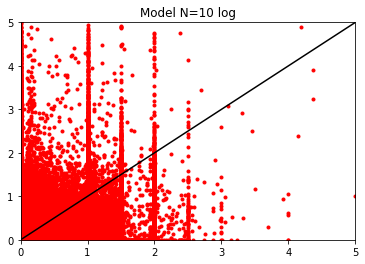

In [123]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 
y_validation = dataset_validation_n10_log['min_tip']

plt.plot(y_validation,y_val_pred_n10_log,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N=10 log')


plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

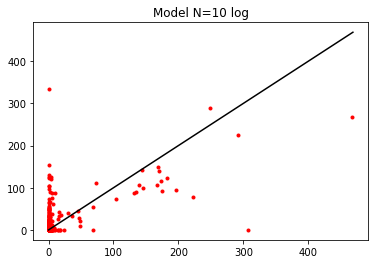

In [124]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 
y_validation = dataset_validation_n10_log['min_tip']

plt.plot(y_validation,y_val_pred_n10_log,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N=10 log')

plt.show()

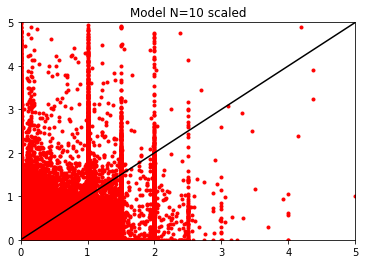

In [125]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 

plt.plot(y_validation,y_val_pred_n10_log,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N=10 scaled')

plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

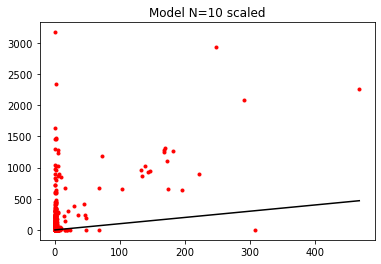

In [147]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 
y_validation = dataset_validation_n10_scaled['min_tip']

plt.plot(y_validation,y_val_pred_n10_scaled,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N=10 scaled')



plt.show()

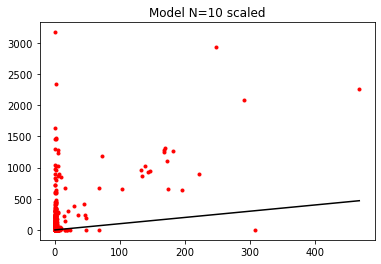

In [148]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 


plt.plot(y_validation,y_val_pred_n10_scaled,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N=10 scaled')

plt.show()

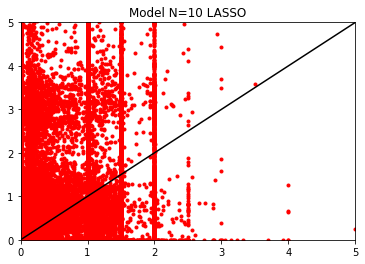

In [153]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 
y_validation = dataset_validation_n10_scaled['min_tip']

plt.plot(y_validation,y_val_pred_lasso,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N=10 LASSO')


plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

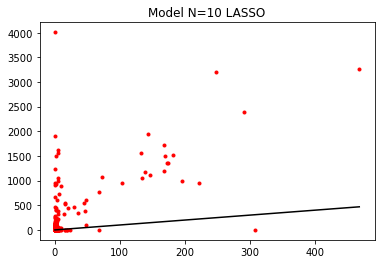

In [150]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 


plt.plot(y_validation,y_val_pred_lasso,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N=10 LASSO')

plt.show()

In [130]:
y_validation = dataset_validation_n3_log['min_tip']
y_val_array = np.array(y_validation)
biggest_error_n3_log=0
for i in range(0,len(y_val_array)):
    if biggest_error_n3_log < abs(y_val_pred_n3_log[i] - y_val_array[i]):
        biggest_error_n3_log= abs(y_val_pred_n3_log[i] - y_val_array[i])

biggest_error_n3_log

326.1273028467706

In [131]:
y_validation = dataset_validation_n10_log['min_tip']
y_val_array = np.array(y_validation)
biggest_error_n10_log=0
for i in range(0,len(y_val_array)):
    if biggest_error_n10_log < abs(y_val_pred_n10_log[i] - y_val_array[i]):
        biggest_error_n10_log= abs(y_val_pred_n10_log[i] - y_val_array[i])

biggest_error_n10_log

333.11937930969856

In [132]:
y_validation = dataset_validation_n10_scaled['min_tip']
y_val_array = np.array(y_validation)
biggest_error_n10_scaled=0
for i in range(0,len(y_val_array)):
    if biggest_error_n10_scaled < abs(y_val_pred_n10_scaled[i] - y_val_array[i]):
        biggest_error_n10_scaled= abs(y_val_pred_n10_scaled[i] - y_val_array[i])

biggest_error_n10_scaled

3172.3494560963695

In [154]:
y_validation = dataset_validation_n10_scaled['min_tip']
y_val_array = np.array(y_validation)
biggest_error_lasso=0
for i in range(0,len(y_val_array)):
    if biggest_error_lasso < abs(y_val_pred_lasso[i] - y_val_array[i]):
        biggest_error_lasso= abs(y_val_pred_lasso[i] - y_val_array[i])

biggest_error_lasso

4009.2878247002423

In [134]:
y_validation = dataset_validation_n3_log['min_tip']
y_val_array = np.array(y_validation)
lower_values_n3_log=0
for i in range(0,len(y_val_array)):
    if y_val_pred_n3_log[i] <= y_val_array[i]:
        lower_values_n3_log=lower_values_n3_log+1

print("Amount of predicted min tip that wouldn't be enough to go through for N=3 log:" , lower_values_n3_log)
print("Percetage of predicted min tip that wouldn't be enough to go through for N=3 log: ", (lower_values_n3_log/len(y_val_array)*100), "%")

Amount of predicted min tip that wouldn't be enough to go through for N=3 log: 51036
Percetage of predicted min tip that wouldn't be enough to go through for N=3 log:  53.13593203398301 %


In [135]:
y_validation = dataset_validation_n10_log['min_tip']
y_val_array = np.array(y_validation)
lower_values_n10_log=0
for i in range(0,len(y_val_array)):
    if y_val_pred_n10_log[i] <= y_val_array[i]:
        lower_values_n10_log=lower_values_n10_log+1

print("Amount of predicted min tip that wouldn't be enough to go through for N=10 log:" , lower_values_n10_log)
print("Percetage of predicted min tip that wouldn't be enough to go through for N=10 log: ", (lower_values_n10_log/len(y_val_array)*100), "%")

Amount of predicted min tip that wouldn't be enough to go through for N=10 log: 52558
Percetage of predicted min tip that wouldn't be enough to go through for N=10 log:  54.72454472569007 %


In [136]:
y_validation = dataset_validation_n10_scaled['min_tip']
y_val_array = np.array(y_validation)
lower_values_n10_scaled=0
for i in range(0,len(y_val_array)):
    if y_val_pred_n10_scaled[i] <= y_val_array[i]:
        lower_values_n10_scaled=lower_values_n10_scaled+1

print("Amount of predicted min tip that wouldn't be enough to go through for N=10 scaled:" , lower_values_n10_scaled)
print("Percetage of predicted min tip that wouldn't be enough to go through for N=10 scaled: ", (lower_values_n10_scaled/len(y_val_array)*100), "%")

Amount of predicted min tip that wouldn't be enough to go through for N=10 scaled: 46578
Percetage of predicted min tip that wouldn't be enough to go through for N=10 scaled:  48.498037296571255 %


In [155]:
y_validation = dataset_validation_n10_scaled['min_tip']
y_val_array = np.array(y_validation)
lower_values_lasso=0
for i in range(0,len(y_val_array)):
    if y_val_pred_lasso[i] <= y_val_array[i]:
        lower_values_lasso=lower_values_lasso+1

print("Amount of predicted min tip that wouldn't be enough to go through for N=10 scaled LASSO:" , lower_values_lasso)
print("Percetage of predicted min tip that wouldn't be enough to go through for N=10 scaled LASSO: ", (lower_values_lasso/len(y_val_array)*100), "%")

Amount of predicted min tip that wouldn't be enough to go through for N=10 scaled LASSO: 46607
Percetage of predicted min tip that wouldn't be enough to go through for N=10 scaled LASSO:  48.52823273393655 %


In [138]:
y_validation = dataset_validation_n3_log['min_tip']
y_val_array = np.array(y_validation)
errors_validation_n3_log = []
for i in range(0,len(y_val_array)):
    if abs(y_val_pred_n3_log[i] - y_val_array[i]) <= 100:
        errors_validation_n3_log.append(y_val_pred_n3_log[i] - y_val_array[i])

errors_validation_n3_log = np.array(errors_validation_n3_log)

In [139]:
y_validation = dataset_validation_n10_log['min_tip']
y_val_array = np.array(y_validation)
errors_validation_n10_log = []
for i in range(0,len(y_val_array)):
    if abs(y_val_pred_n10_log[i] - y_val_array[i]) <= 100:
        errors_validation_n10_log.append(y_val_pred_n10_log[i] - y_val_array[i])

errors_validation_n10_log = np.array(errors_validation_n10_log)

In [140]:
y_validation = dataset_validation_n10_scaled['min_tip']
y_val_array = np.array(y_validation)
errors_validation_n10_scaled = []
for i in range(0,len(y_val_array)):
    if abs(y_val_pred_n10_scaled[i] - y_val_array[i]) <= 100:
        errors_validation_n10_scaled.append(y_val_pred_n10_scaled[i] - y_val_array[i])

errors_validation_n10_scaled = np.array(errors_validation_n10_scaled)

In [156]:
y_validation = dataset_validation_n10_scaled['min_tip']
y_val_array = np.array(y_validation)
errors_validation_lasso = []
for i in range(0,len(y_val_array)):
    if abs(y_val_pred_lasso[i] - y_val_array[i]) <= 100:
        errors_validation_lasso.append(y_val_pred_lasso[i] - y_val_array[i])

errors_validation_lasso = np.array(errors_validation_lasso)

Text(0, 0.5, '# blocks')

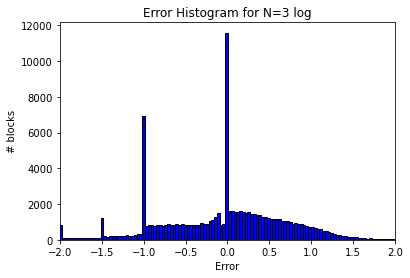

In [141]:
plt.hist(errors_validation_n3_log, bins = 5000, color = 'blue', edgecolor = 'black')
plt.xlim(-2,2)
plt.title('Error Histogram for N=3 log')
plt.xlabel('Error')
plt.ylabel('# blocks')

Text(0, 0.5, '# blocks')

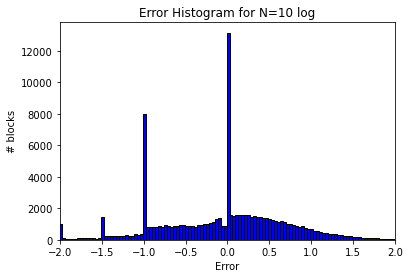

In [142]:
plt.hist(errors_validation_n10_log, bins = 5000, color = 'blue', edgecolor = 'black')
plt.xlim(-2,2)
plt.title('Error Histogram for N=10 log')
plt.xlabel('Error')
plt.ylabel('# blocks')

Text(0, 0.5, '# blocks')

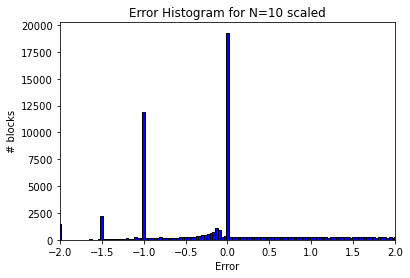

In [143]:
plt.hist(errors_validation_n10_scaled, bins = 5000, color = 'blue', edgecolor = 'black')
plt.xlim(-2,2)
plt.title('Error Histogram for N=10 scaled')
plt.xlabel('Error')
plt.ylabel('# blocks')

Text(0, 0.5, '# blocks')

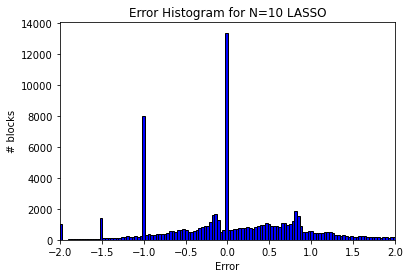

In [157]:
plt.hist(errors_validation_lasso, bins = 5000, color = 'blue', edgecolor = 'black')
plt.xlim(-2,2)
plt.title('Error Histogram for N=10 LASSO')
plt.xlabel('Error')
plt.ylabel('# blocks')